# Term Deposit Subscription Prediction Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, precision_score, recall_score, classification_report

### 1.0 Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

### Input variables:
#### bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')




In [40]:
df = pd.read_csv('bank-full.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [41]:
# Shape of the dataset
df.shape

(45211, 17)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [43]:
# Numerical variables
numerical = df.select_dtypes ( exclude = "object" )
print ( "Numerical columns:" )
c = 1
for i in numerical.columns:
    print ( c , "." , i )
    c += 1

Numerical columns:
1 . age
2 . balance
3 . day
4 . duration
5 . campaign
6 . pdays
7 . previous


In [6]:
# Categorical variables
categorical = df.select_dtypes ( include = "object" )
print ( "Categorical columns:" )
c = 1
for i in categorical.columns:
    print ( c , "." , i )
    c += 1

Categorical columns:
1 . job
2 . marital
3 . education
4 . default
5 . housing
6 . loan
7 . contact
8 . month
9 . poutcome
10 . Target


#### 1.1 Five Point Summary

In [7]:
numerical.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
categorical.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,Target
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


The job variable has a high number of classes and possibly could be narrowed down to a few classes.

#### 1.2 Missing values

In [9]:
df.isnull ( ).sum ( )

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

The dataset has no missing values.

### 2.0 Exploratory Data Analysis

In [34]:
def categorical_count_plot(data_frame):
    for i in categorical.columns:
        print("Column:" , i)
        print(data_frame[i].value_counts())
        f, ax = plt.subplots (figsize=(7 ,5))
        sns.countplot (data_frame[i])
        plt.xticks (rotation = 45)
        plt.show ()
        print("\n")

In [35]:
def numerical_analysis_plot(data_frame):
    for i in numerical.columns:
        print ("Column:" , i)
        print ("Skewness for {} is {}".format(i ,round(data_frame[i].skew(),3)))
        sns.distplot(data_frame[i])
        plt.show()

#### 2.1 categorical variables

In [12]:
categorical.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'Target'],
      dtype='object')

Column: job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64


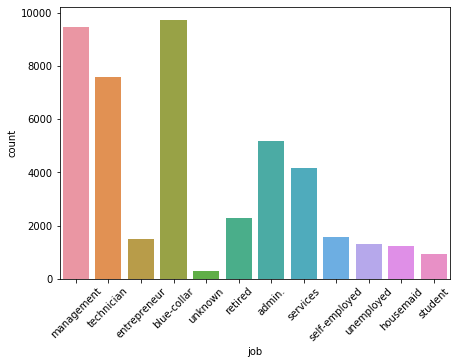



Column: marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


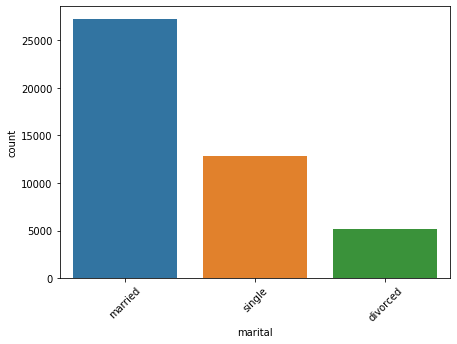



Column: education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


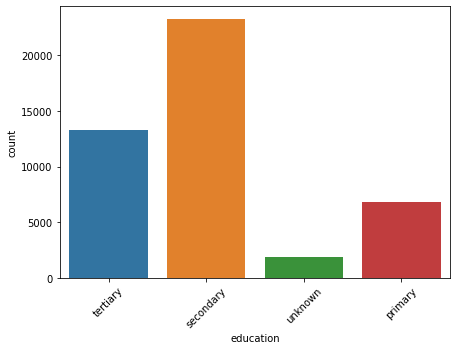



Column: default
no     44396
yes      815
Name: default, dtype: int64


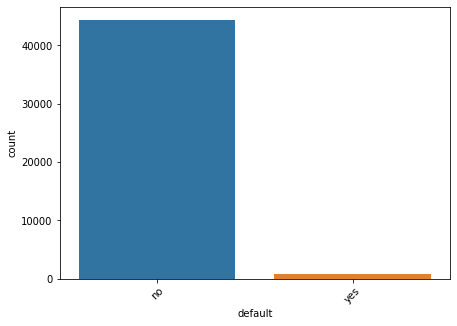



Column: housing
yes    25130
no     20081
Name: housing, dtype: int64


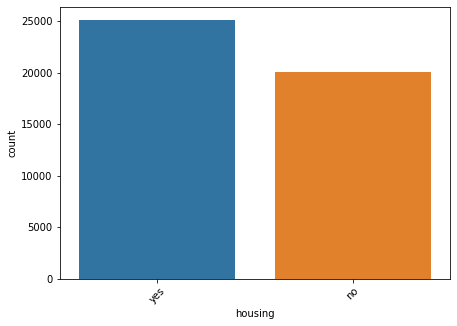



Column: loan
no     37967
yes     7244
Name: loan, dtype: int64


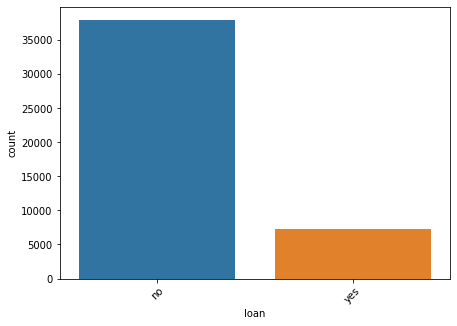



Column: contact
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64


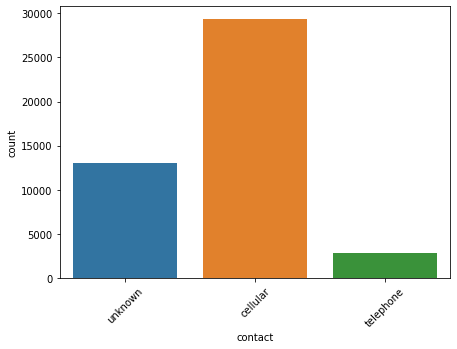



Column: month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64


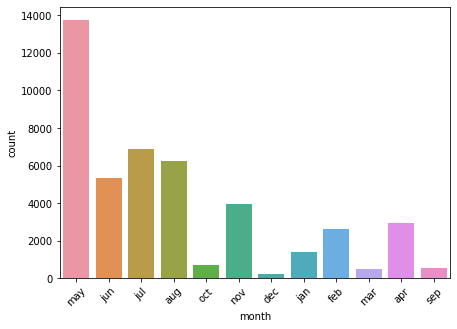



Column: poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64


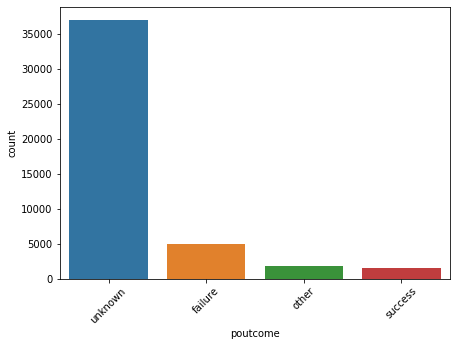



Column: Target
no     39922
yes     5289
Name: Target, dtype: int64


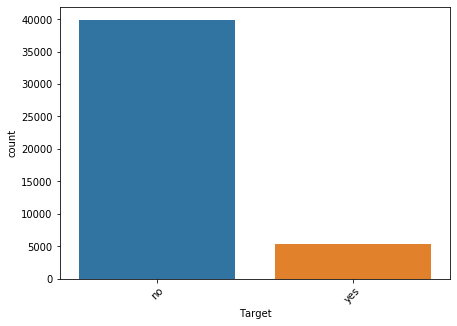

In [13]:
categorical_count_plot(df)

The following is observed from the categorical features;

* The target variable is highly imbalanced.
* The outcome of the previous marketing campaign has a high numbers of unknown outcome. Feature importance will be used to comfirm if it adds any predictive value.
* The default feature is extremely imbalanced and could also add no predictive value.

#### 2.2 Numerical variables
#### 2.2.1 Univariate Analysis

In [15]:
numerical.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

Column: age
Skewness for age is 0.685


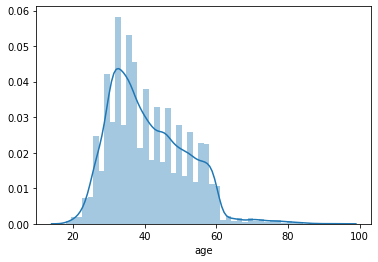

Column: balance
Skewness for balance is 8.36


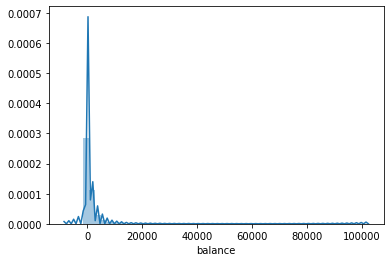

Column: day
Skewness for day is 0.093


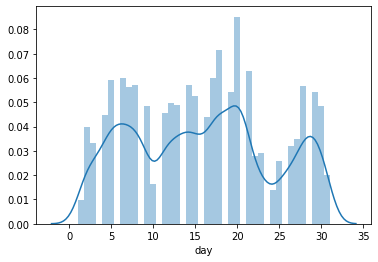

Column: duration
Skewness for duration is 3.144


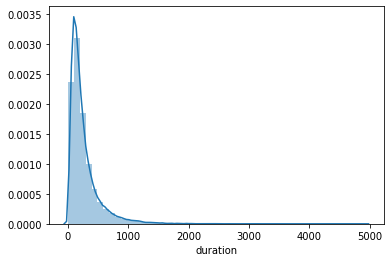

Column: campaign
Skewness for campaign is 4.899


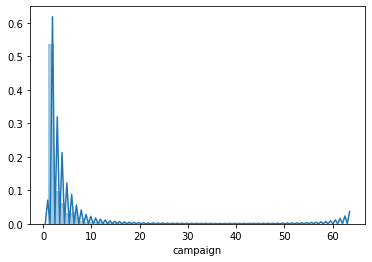

Column: pdays
Skewness for pdays is 2.616


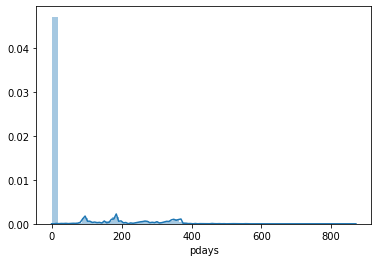

Column: previous
Skewness for previous is 41.846


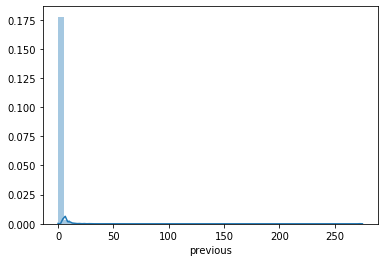

In [16]:
numerical_analysis_plot(df)

The following is observed from the numerical features;

* The age feature has a long tail to the right which means possible outliers with age over 90 years. One would question if the age is useful for the campaign. 
* The rest of the features have very high skweness with heavy tails indicating outliers. This is evident from the Five point summay in section 1.1  The previous feature has a skewness of 41.8 and would need to be checked for extreme outliers.
* The day feature has possibly a multimodal distibution.
* The features would need to be normalized for model building.

In [16]:
# Age feature analysis
df.query("age >= 75")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
29158,83,retired,married,primary,no,425,no,no,telephone,2,feb,912,1,-1,0,unknown,no
29261,75,retired,divorced,primary,no,46,no,no,cellular,2,feb,294,1,-1,0,unknown,no
29263,75,retired,married,primary,no,3324,no,no,cellular,2,feb,149,1,-1,0,unknown,no
29322,83,retired,married,tertiary,no,6236,no,no,cellular,2,feb,283,2,-1,0,unknown,no
29865,75,retired,divorced,primary,no,3881,yes,no,cellular,4,feb,136,3,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,77,retired,divorced,primary,no,2693,no,no,cellular,25,oct,83,2,94,12,other,no
45109,78,management,married,unknown,no,1780,yes,no,cellular,25,oct,211,2,185,7,success,yes
45118,78,retired,married,primary,no,14204,no,no,cellular,26,oct,150,1,183,1,other,no
45141,77,unknown,married,unknown,no,397,no,no,telephone,8,nov,207,1,185,3,success,no


130 rows with age above 75 will be removed, since the dataset is large, model building would not be affected.

#### 2.2.2 Bivariate Analysis

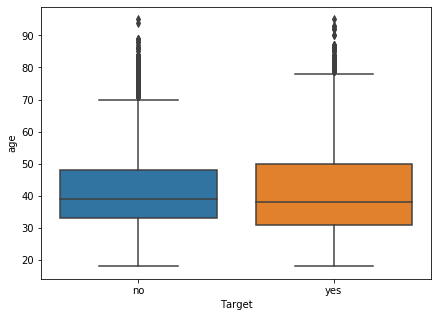

In [18]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxplot(categorical[ "Target" ] , numerical[ "age" ] )
plt.show ( )

More older respondants than younger responded favourably to the campaign.

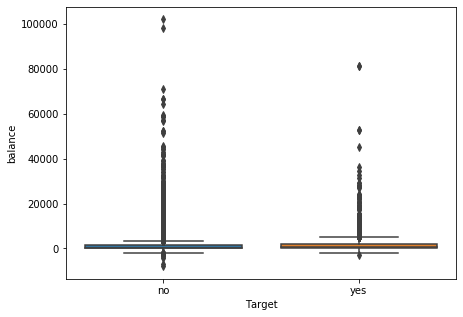

In [20]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxplot (categorical[ "Target" ] , numerical[ "balance" ] )
plt.show ( )

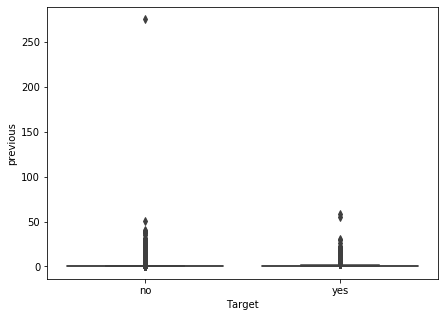

In [22]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxplot (categorical[ "Target" ] , numerical[ "previous" ] )
plt.show ( )

Respondants with a high balance are more likely to reject the product.

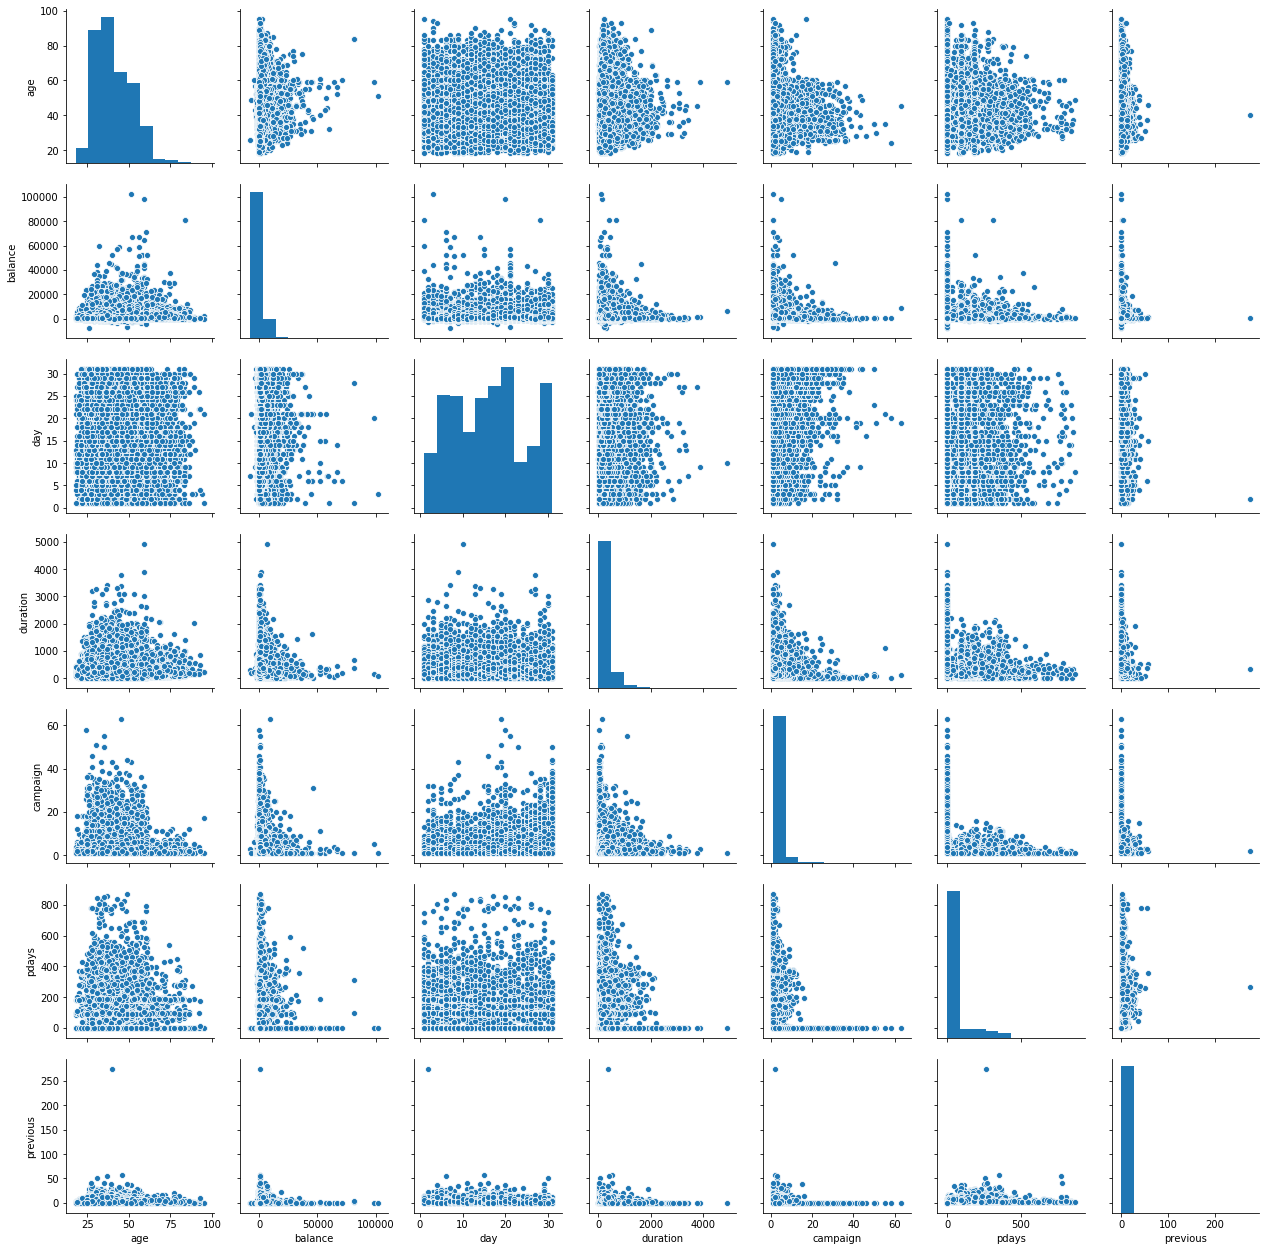

In [23]:
sns.pairplot(df)

In [18]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,age,balance,day,duration,campaign,pdays,previous
age,1,0.0977827,-0.00912005,-0.00464843,0.00476031,-0.023758,0.00128832
balance,0.0977827,1,0.00450259,0.0215604,-0.0145783,0.00343532,0.0166736
day,-0.00912005,0.00450259,1,-0.0302063,0.16249,-0.0930441,-0.0517105
duration,-0.00464843,0.0215604,-0.0302063,1,-0.0845695,-0.00156477,0.00120306
campaign,0.00476031,-0.0145783,0.16249,-0.0845695,1,-0.0886277,-0.0328553
pdays,-0.023758,0.00343532,-0.0930441,-0.00156477,-0.0886277,1,0.45482
previous,0.00128832,0.0166736,-0.0517105,0.00120306,-0.0328553,0.45482,1


The correlation matrix shows that the predictive features are independent, showing no significant dependency.

### 3.0 Model Building

#### 3.1 Data Preprocessing

#### 3.1.1 removing outliers

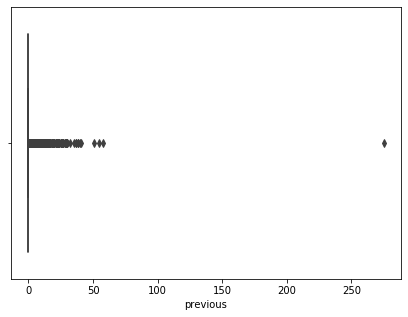

In [45]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxplot ( numerical[ "previous" ] )
plt.show ( )

Its not possible that one person would have been called 275 times. This record will be deleted

In [46]:
# previous feature analysis
df.query("previous >= 100")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no


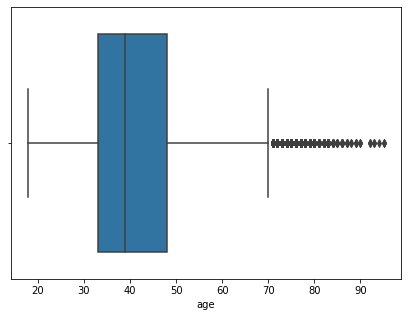

In [47]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxplot (df[ "age" ] )
plt.show ( )

In [48]:
# age feature analysis
df.query("age >= 70")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
29158,83,retired,married,primary,no,425,no,no,telephone,2,feb,912,1,-1,0,unknown,no
29261,75,retired,divorced,primary,no,46,no,no,cellular,2,feb,294,1,-1,0,unknown,no
29263,75,retired,married,primary,no,3324,no,no,cellular,2,feb,149,1,-1,0,unknown,no
29322,83,retired,married,tertiary,no,6236,no,no,cellular,2,feb,283,2,-1,0,unknown,no
29324,70,management,married,tertiary,no,13297,no,no,cellular,2,feb,579,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45183,70,retired,married,primary,no,324,no,no,cellular,15,nov,78,1,96,7,success,no
45191,75,retired,divorced,tertiary,no,3810,yes,no,cellular,16,nov,262,1,183,1,failure,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes


In [52]:
df = df.query("age < 70")
df.shape

(44657, 17)

In [53]:
df = df.query("previous < 100")
df.shape

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [68]:
del df['duration']

In [69]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,1,-1,0,unknown,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,2,-1,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no


In [70]:
df.shape

(44656, 16)

pdays feature has negative values of number days passed after the last call to the client. 

In [72]:
df.query("pdays < 0")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,1,-1,0,unknown,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,1,-1,0,unknown,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,2,-1,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes


Too many rows have a negative values, we remove this feature since it does not make sense.

In [73]:
del df['pdays']

In [74]:
# clean dataset
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,1,0,unknown,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,2,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,0,unknown,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,0,unknown,no


In [75]:
df.shape

(44656, 15)

#### 3.1.2 One-Hot Encoding

In [92]:
oneHotCols=["education", "job","marital","default","housing", "loan", "contact", "month", "poutcome", "Target"]

In [93]:
df_clean=pd.get_dummies(df, columns=oneHotCols, drop_first = True)

In [94]:
df_clean

,age,balance,day,campaign,previous,education_secondary,education_tertiary,education_unknown,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,Target_yes
0,58,2143,5,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,44,29,5,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,33,2,5,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,33,1,5,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,113,17,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
45205,25,505,17,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
45206,51,825,17,3,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
45209,57,668,17,4,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [95]:
features = df_clean.drop(['Target_yes'], axis = 1) 
target = df_clean['Target_yes']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, stratify=target)

In [97]:
print(len(X_train))
print(len(y_test))

31259
13397


#### 3.2  Standard Classification Model - Decision Tree

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

We set the 'entropy' for calculation of purity however, the is not much difference in results if 'gini' is used. Entropy takes slightly more computation time than Gini Index because of the log calculation. Other key hyperparameters are the maximum depth of the tree, class weights and minimum sample split. Default parameters were used.

In [154]:
dt_model = DecisionTreeClassifier(criterion = 'entropy')

In [155]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [156]:
tree_predictions = dt_model.predict(X_test)

In [157]:
#Scoring our Decision Tree
print(dt_model.score(X_train, y_train))
print(dt_model.score(X_test, y_test))

1.0
0.8305590803911324


In [158]:
#Feature importance
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                          Imp
age                  0.149588
balance              0.251537
day                  0.122554
campaign             0.054561
previous             0.029966
education_secondary  0.015990
education_tertiary   0.014038
education_unknown    0.006090
job_blue-collar      0.015595
job_entrepreneur     0.004978
job_housemaid        0.004420
job_management       0.015959
job_retired          0.004058
job_self-employed    0.006027
job_services         0.010680
job_student          0.003502
job_technician       0.014739
job_unemployed       0.008308
job_unknown          0.000825
marital_married      0.013825
marital_single       0.010768
default_yes          0.001241
housing_yes          0.013369
loan_yes             0.010649
contact_telephone    0.007307
contact_unknown      0.023052
month_aug            0.009020
month_dec            0.003309
month_feb            0.008365
month_jan            0.006657
month_jul            0.010184
month_jun            0.012330
month_mar 

In [105]:
from yellowbrick.classifier import ClassificationReport, ROCAUC

In [106]:
# Confusion matrix
pd.crosstab(y_test, tree_predictions, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,10673,1208
1,1043,473


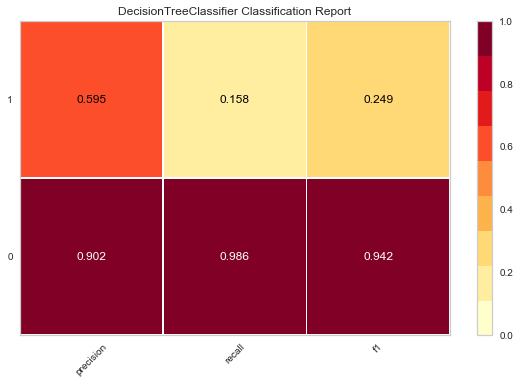

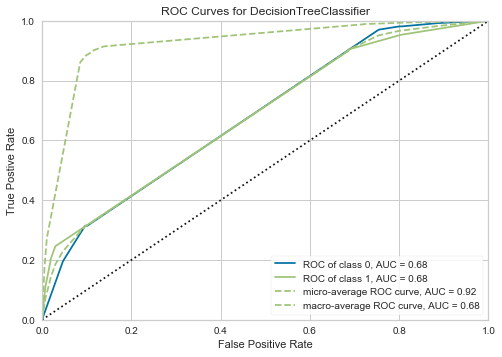

In [107]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(DecisionTreeClassifier(criterion = "entropy", max_depth=4))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(DecisionTreeClassifier(criterion = "entropy", max_depth=4))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

The following are the advantages/dissadvantages of the decision tree algorithm:

* Advantages
    * Compared to other algorithms decision trees requires less effort for data preparation during pre-processing.
    * A decision tree does not require normalization of data.
    * A decision tree does not require scaling of data as well.
    * A Decision trees model is very intuitive and easy to explain to technical teams as well as stakeholders.
    
* Dissadvantages
    * A small change in the data can cause a large change in the structure of the decision tree causing instability
    * Decision tree training is relatively expensive as complexity and time taken is more.
    * Prone to over fitting

#### 3.3 Random Forest

In [108]:
from sklearn.ensemble import RandomForestRegressor

In [109]:
rf_model = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12)

In [110]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [111]:
rf_predictions = rf_model.predict(X_test)

In [131]:
#Feature importance
print (pd.DataFrame(rf_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                          Imp
age                  0.145038
balance              0.198243
day                  0.133426
campaign             0.057392
previous             0.030186
education_secondary  0.019636
education_tertiary   0.015867
education_unknown    0.007162
job_blue-collar      0.014118
job_entrepreneur     0.005716
job_housemaid        0.004969
job_management       0.015811
job_retired          0.005601
job_self-employed    0.006547
job_services         0.011232
job_student          0.005326
job_technician       0.016823
job_unemployed       0.008172
job_unknown          0.001319
marital_married      0.014225
marital_single       0.013631
default_yes          0.002624
housing_yes          0.023578
loan_yes             0.015124
contact_telephone    0.009228
contact_unknown      0.012230
month_aug            0.011153
month_dec            0.004277
month_feb            0.010391
month_jan            0.007537
month_jul            0.011659
month_jun            0.013503
month_mar 

In [112]:
# Confusion matrix
pd.crosstab(y_test, rf_predictions, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,11654,227
1,1203,313


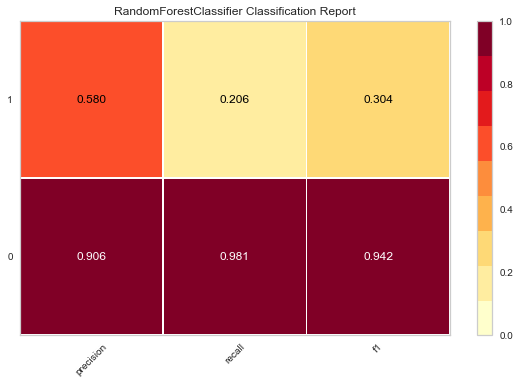

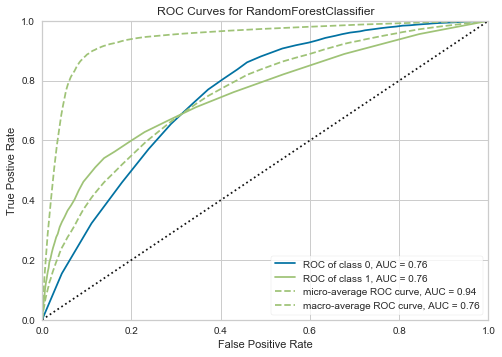

In [113]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

In [114]:
accuracy = metrics.accuracy_score(y_test, rf_predictions)
accuracy_percentage = 100 * accuracy
accuracy_percentage

89.32596850041054

#### 3.3.1 Hyperparameter Optimization

In [115]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [116]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# spliting option
criterion= ['entropy','gini']

In [117]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['entropy', 'gini']}


In [122]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid,n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [123]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=12,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
      

In [124]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': False}

In [125]:
rf_model2 = RandomForestClassifier(n_estimators = 800,
 min_samples_split = 10,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
 bootstrap = False, criterion='gini')

In [126]:
rf_model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [127]:
rf_predictions2 = rf_model2.predict(X_test)

In [128]:
# Confusion matrix
pd.crosstab(y_test, rf_predictions2, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,11684,197
1,1218,298


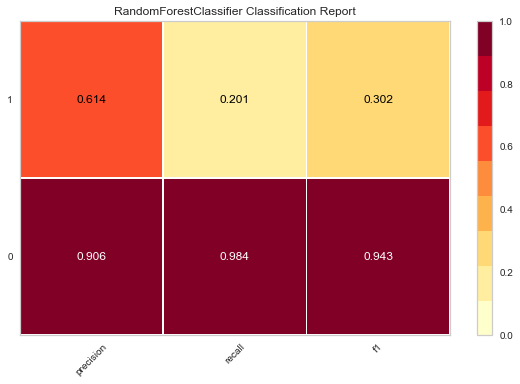

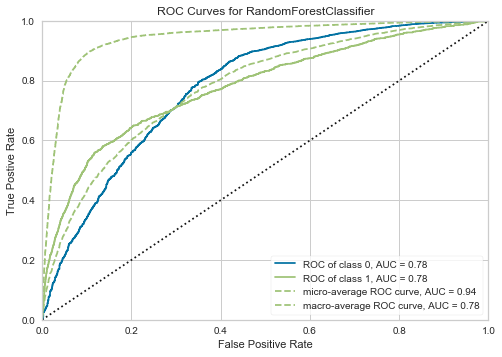

In [129]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(RandomForestClassifier(n_estimators = 800,
 min_samples_split = 10,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
 bootstrap = False))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(RandomForestClassifier(n_estimators = 800,
 min_samples_split = 10,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
 bootstrap = False))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

In [130]:
accuracy = metrics.accuracy_score(y_test, rf_predictions2)
accuracy_percentage = 100 * accuracy
accuracy_percentage

89.43793386579085

### 4.0 Conclusion

The **Decision Tree** model was used as the base model and achieved an accuracy of **83.2%**. The **Ensemble model** subsequantly improved the accuracy to **89.33%**. Hyperparameter optimization was carried out using a grid search and slightly improved the accuracy to **89.44%**  showing that the initial choosen parameters were near optimal.